# Testing vaccinated and unvaccinated population outcomes

In [23]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

from scseirx import analysis_functions as af

import data_creation_functions as dcf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Simulation settings

In [2]:
with open('params/vaccinations_measures.json', 'r') as fp:
    measures = json.load(fp)
with open('params/vaccinations_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
with open('params/vaccinations_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

In [31]:
simulation_params

{'verbosity': 0,
 'base_transmission_risk': 0.07367,
 'subclinical_modifier': 0.6,
 'exposure_duration': [5.0, 1.9],
 'time_until_symptoms': [6.4, 0.8],
 'infection_duration': [10.91, 3.95],
 'student_index_probability': 0,
 'teacher_index_probability': 0,
 'family_member_index_probability': 0,
 'infection_risk_contact_type_weights': {'very_far': 0,
  'far': 0.26,
  'intermediate': 0.26,
  'close': 1},
 'age_transmission_discount': {'slope': 0, 'intercept': 1},
 'age_symptom_discount': {'slope': -0.02868, 'intercept': 0.7954411542069012},
 'mask_filter_efficiency': {'exhale': 0.5, 'inhale': 0.7}}

## Simulation function

In [4]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, ttype, s_screen_interval, t_screen_interval,\
        student_mask, teacher_mask, half_classes, ventilation_mod,\
        student_vaccination_ratio, teacher_vaccination_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, ttype, s_screen_interval, t_screen_interval,\
            student_mask, teacher_mask, half_classes, ventilation_mod,
             student_vaccination_ratio, teacher_vaccination_ratio)
    
    ensmbl_results['school_type'] = school_type
    ensmbl_results['index_case'] = index_case
    ensmbl_results['test_type'] = ttype
    ensmbl_results['student_screen_interval'] = s_screen_interval
    ensmbl_results['teacher_screen_interval'] = t_screen_interval
    ensmbl_results['student_mask'] = student_mask
    ensmbl_results['teacher_mask'] = teacher_mask
    ensmbl_results['half_classes'] = half_classes
    ensmbl_results['ventilation_mod'] = ventilation_mod
    ensmbl_results['student_vaccination_ratio'] = student_vaccination_ratio
    ensmbl_results['teacher_vaccination_ratio'] = teacher_vaccination_ratio
    
    return ensmbl_results

## Screening parameters

In [26]:
## parameter ranges 

# number of runs in the ensemble
# Note: this is set to 1 for testing purposes. To get properly converged 
# statistics, this has to be >= 500. Running such a high number of simulations
# will take a long time if run on just a single core. Therefore I strongly
# recommend to run the below code on several cores at once. It is easy to
# parallelize as each ensemble can be run on a different core and there are
# no interdependencies between ensembles. Results can be collected afterwards
# and evaulated together.
N_runs = 100
# different school types
school_types = ['primary']
# specifies whether the index case will be introduced via an
# employee or a resident
index_cases = ['student', 'teacher']
# test technologies (and test result turnover times) used in the
# different scenarios
test_types = ['same_day_antigen']
# student and teacher streening intervals (in days)
s_screen_range = [None]
t_screen_range = [None]
# specifies whether teachers wear masks
student_masks = [False]
teacher_masks = [False]
half_classes = [False]
# specifies whether there is ventilation or not
transmission_risk_ventilation_modifiers = [1]
# specifies the ratio of vaccinated students
student_vaccination_ratios = [0, 0.5, 1.0]
teacher_vaccination_ratios = [0, 0.5, 1.0]

params = [(N_runs, i, j, k, l, m, n, o, p, q, r, s)\
              for i in school_types \
              for j in index_cases \
              for k in test_types \
              for l in s_screen_range \
              for m in t_screen_range \
              for n in student_masks \
              for o in teacher_masks \
              for p in half_classes \
              for q in transmission_risk_ventilation_modifiers \
              for r in student_vaccination_ratios \
              for s in teacher_vaccination_ratios]

N_configs = len(params)
print('there are {} different parameter combinations'.format(N_configs))

there are 18 different parameter combinations


In [27]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/vaccinations/testing'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run, iterable=params),
                           total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case', 'test_type',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'half_classes',
              'ventilation_mod', 'student_vaccination_ratio',
              'teacher_vaccination_ratio']
interesting_cols = ['index_case', 'student_vaccination_ratio', 
                    'teacher_vaccination_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[interesting_cols + other_cols]

results.to_csv(join(dst, 'vaccinations_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 18/18 [03:28<00:00, 11.61s/it]

CPU times: user 256 ms, sys: 109 ms, total: 366 ms
Wall time: 3min 29s


,index_case,student_vaccination_ratio,teacher_vaccination_ratio,N_diagnostic_tests,N_family_members,N_preventive_tests,N_school_agents,R0,diagnostic_test_detected_infections_family_member,diagnostic_test_detected_infections_student,...,run,seed,student_family_member_transmissions,student_student_transmissions,student_teacher_transmissions,teacher_student_transmissions,teacher_teacher_transmissions,tests_per_day_per_agent,transmissions,undetected_infections
0,teacher,0.5,0.0,1.0,346.0,0.0,164.0,3.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.000218,4.0,0.0
1,teacher,0.5,0.0,2.0,346.0,0.0,164.0,1.0,1.0,1.0,...,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.000436,2.0,0.0
2,teacher,0.5,0.0,2.0,346.0,0.0,164.0,1.0,0.0,2.0,...,3.0,3.0,1.0,2.0,1.0,3.0,0.0,0.000194,7.0,0.0


In [28]:
def set_vaccination_scenario(row):
    vaccination_scenario = 'student {:1.2f}\nteacher {:1.2f}'\
    .format(row['student_vaccination_ratio'], row['teacher_vaccination_ratio'])
    return vaccination_scenario

In [29]:
results = pd.read_csv(join(dst, 'vaccinations_{}.csv'.format(N_runs)))
results['vaccination_scenario'] = results.apply(set_vaccination_scenario, axis=1)

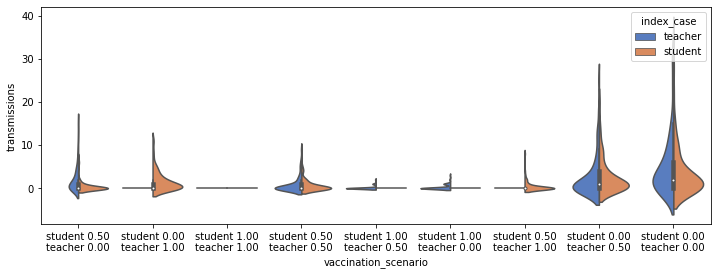

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.violinplot(x="vaccination_scenario", y="transmissions", hue="index_case",
                    data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=10)